In [1]:
!pip uninstall opencv-python opencv-contrib-python opencv-python-headless opencv-contrib-python-headless -y
!pip install opencv-contrib-python
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
!pip install ultralytics
import ultralytics
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO
import wandb
wandb.init(mode="disabled")

Found existing installation: opencv-python 4.9.0.80
Uninstalling opencv-python-4.9.0.80:
  Successfully uninstalled opencv-python-4.9.0.80
Found existing installation: opencv-contrib-python 4.9.0.80
Uninstalling opencv-contrib-python-4.9.0.80:
  Successfully uninstalled opencv-contrib-python-4.9.0.80
Found existing installation: opencv-python-headless 4.9.0.80
Uninstalling opencv-python-headless-4.9.0.80:
  Successfully uninstalled opencv-python-headless-4.9.0.80
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 24.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 18.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 26.6 MB/s eta 0:00:00:00:0100:01


In [2]:
if os.path.exists('dataset2'):
    shutil.rmtree('dataset')
shutil.copytree('/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class', 'dataset')

'dataset'

In [3]:
files = os.listdir('dataset/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)


00304_107


Nhãn lớp: 1
Tọa độ tâm (x, y): 0.306729 0.516432
Chiều rộng: 0.201878
Chiều cao: 0.199531


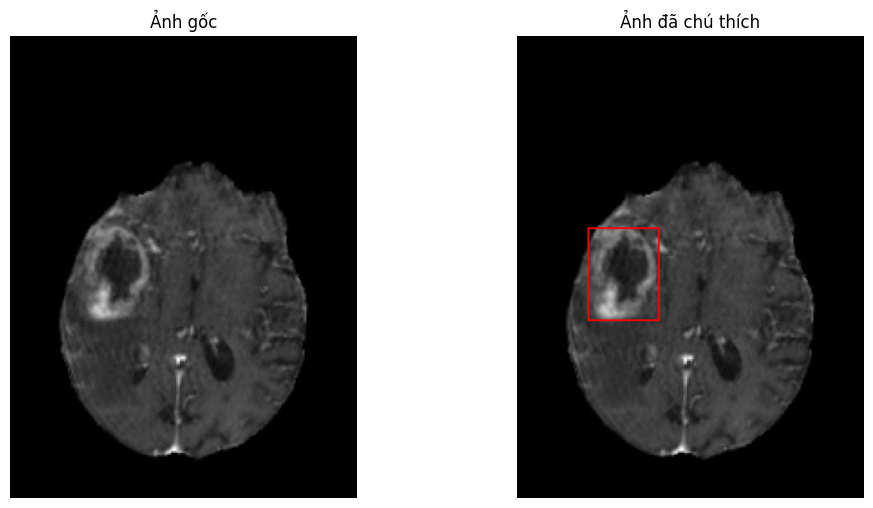

In [4]:
with open(os.path.join('dataset/labels/train', f'{random_file}.txt'), 'r') as f:
    labels = f.readline().split(' ')

# In thông tin của nhãn
print("Nhãn lớp:", int(labels[0]))
print("Tọa độ tâm (x, y):", float(labels[1]), float(labels[2]))
print("Chiều rộng:", float(labels[3]))
print("Chiều cao:", float(labels[4]))

# Đọc và xử lý hình ảnh
img = cv2.imread(os.path.join('dataset/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Sao chép hình ảnh 
annotated_img = img.copy()

# Xác định vị trí và kích thước của hình chữ nhật
tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

# Xác định màu sắc của hình chữ nhật dựa trên loại u
if tumor_class == 1:
    colour = (255, 0, 0)  # Màu đỏ
else:
    colour = (0, 255, 0)  # Màu xanh lá cây

# Vẽ hình chữ nhật trên hình ảnh được sao chép
cv2.rectangle(annotated_img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

# Hiển thị hình ảnh gốc và hình ảnh đã được chú thích
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title('Ảnh gốc')
axes[0].axis('off')
axes[1].imshow(annotated_img)
axes[1].set_title('Ảnh đã chú thích')
axes[1].axis('off')
plt.show()


In [5]:
# Lấy danh sách tất cả các tệp tin ảnh trong thư mục train và test
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')

# Lấy danh sách tất cả các tệp tin nhãn trong thư mục train và test
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

# Đếm số lượng ảnh và nhãn trong tập train và tập test
num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

#In số lượng ảnh và nhãn trong train và test
print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

310 75
296 75


In [6]:
# Xử lý dữ liệu: Loại bỏ các ảnh không có nhãn tương ứng từ tập huấn luyện
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

#Xóa ảnh không có nhãn từ tập tương ứng
for image in unlabelled:
    os.remove(os.path.join('dataset/images/train', image))


In [7]:
# Lấy danh sách tất cả các tệp tin ảnh trong thư mục train và test
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')

# Lấy danh sách tất cả các tệp tin nhãn trong thư mục train và test
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

# Đếm số lượng ảnh và nhãn trong tập train và tập test
num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

#In số lượng ảnh và nhãn trong train và test
print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

296 75
296 75


In [8]:
# Tính toán số lượng ảnh cho tập validation (20%)
val_split = int(num_train_images * 0.2)

# Lấy ngẫu nhiên các ảnh cho tập validation
val_images = random.sample(train_images, val_split)

# Kiểm tra và xóa thư mục validation nếu tồn tại
if os.path.exists('dataset/images/val'):
    shutil.rmtree('dataset/images/val')
if os.path.exists('dataset/labels/val'):
    shutil.rmtree('dataset/labels/val')

# Tạo thư mục validation
os.makedirs('./dataset/images/val')
os.makedirs('./dataset/labels/val')

# Di chuyển các ảnh và nhãn tương ứng sang thư mục validation
for image in val_images:
    # Di chuyển ảnh sang thư mục validation
    shutil.move(os.path.join('dataset/images/train', image), 'dataset/images/val')
    # Tạo tên nhãn từ tên ảnh và di chuyển nhãn sang thư mục validation
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('dataset/labels/train', label), 'dataset/labels/val')

# Đếm số lượng ảnh trong thư mục validation sau khi chuyển
num_val_images = len(os.listdir('dataset/images/val'))

# Hiển thị số lượng ảnh trong tập validation
print("Số lượng ảnh trong tập validation:", num_val_images)

Số lượng ảnh trong tập validation: 59


In [9]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
# Ghi nội dung của chuỗi vào tệp YAML
with open("./fixed_path.yaml", 'w') as file:
    file.write(text)

In [10]:
# import yaml

# # Đọc nội dung từ tệp YAML
# with open("./fixed_path.yaml", 'r') as file:
#     data = yaml.safe_load(file)

# # Hiển thị dữ liệu đã đọc
# print(data)


In [11]:
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 201MB/s]


In [12]:
# Hiển thị thông tin về mô hình
print(model)


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [13]:
results = model.train(data='/kaggle/working/fixed_path.yaml', epochs=250, device=0)

Ultralytics YOLOv8.2.1 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/fixed_path.yaml, epochs=250, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

100%|██████████| 755k/755k [00:00<00:00, 18.6MB/s]
2024-04-18 16:27:53,378	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-18 16:27:55,218	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-18 16:27:57.364838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 16:27:57.364960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 16:27:57.479733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 105MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<00:00, 1311.17it/s]

train: New cache created: /kaggle/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/dataset/labels/val... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 1792.02it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      4.67G      1.842      5.131      1.607         18        640: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all         59         63      0.312       0.25      0.213      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      4.56G      1.287      2.373      1.203         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


                   all         59         63      0.488      0.357      0.337      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      4.58G       1.15      1.746      1.142         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         59         63     0.0123      0.381     0.0112    0.00714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      4.58G      1.222      1.633      1.142         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


                   all         59         63      0.291      0.502      0.273      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      4.56G      1.165       1.48      1.145         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


                   all         59         63      0.214      0.107     0.0858     0.0486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      4.58G      1.298      1.468      1.196         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         59         63    0.00279     0.0476   0.000767   0.000478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      4.57G      1.234      1.415      1.199         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         59         63    0.00104     0.0714   0.000577   0.000131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      4.57G      1.235      1.429      1.128         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         59         63      0.108      0.667     0.0568     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      4.56G      1.181      1.316      1.135         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]


                   all         59         63      0.259      0.619      0.394      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      4.59G      1.263      1.265      1.172         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         63      0.564      0.548      0.603      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      4.57G      1.158      1.306      1.134         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         63      0.558      0.714      0.606      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      4.57G      1.096      1.164      1.092         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         63      0.611       0.69      0.707       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      4.56G      1.142      1.264      1.129         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         63      0.543      0.536      0.515      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      4.57G      1.162      1.182      1.128         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         63      0.728      0.619      0.705      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      4.58G      1.093      1.135      1.092         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         63       0.65      0.679      0.676      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      4.57G      1.094      1.047      1.139         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         63      0.322      0.619      0.495      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      4.57G      1.116      1.075      1.107         39        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


                   all         59         63      0.397      0.554       0.48      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      4.58G      1.147      1.127      1.116         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         63      0.764      0.674      0.711      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      4.58G      1.092      1.085      1.109         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         59         63      0.721      0.675      0.731      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      4.59G      1.047     0.9965      1.051         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         63      0.717      0.702      0.806      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      4.57G      1.073      1.023      1.099         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         59         63      0.681      0.774      0.791      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      4.57G       1.03     0.9918      1.036         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         63      0.813      0.593      0.671      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      4.58G      1.048      0.961      1.058         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         63      0.739      0.674      0.726      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      4.57G      1.105     0.9231      1.086         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         59         63      0.573       0.75      0.703      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      4.57G      1.087      1.069      1.095         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         63      0.547      0.626      0.551      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      4.57G      1.038     0.9597      1.047         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         59         63      0.533      0.802      0.673      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      4.57G      1.022     0.9536      1.063         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         59         63       0.58      0.714      0.674      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      4.58G      1.111      1.016      1.105         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         59         63      0.806      0.524      0.691      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      4.58G      1.049     0.9025      1.069         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         63      0.694      0.668      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      4.59G      1.059     0.9159      1.071         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         59         63      0.629      0.885      0.816      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      4.58G      1.043     0.8777      1.064         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         59         63      0.571      0.726      0.744      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      4.59G     0.9907     0.8275      1.031         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         63      0.802      0.679       0.72      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      4.57G     0.9824     0.8175      1.053         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         63      0.798      0.679      0.799      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      4.58G       1.01     0.8231      1.051         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         59         63      0.675      0.774      0.792      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      4.57G     0.9662       0.84      1.042         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         59         63      0.757      0.702      0.729       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      4.59G     0.9954      0.821      1.041         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         63       0.64      0.763      0.815      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      4.57G      1.023     0.8814      1.059         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         59         63      0.696      0.833      0.854      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      4.57G     0.9893       0.83      1.044         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         63      0.742      0.843      0.873      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      4.56G     0.9769     0.8463      1.041         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         63      0.763       0.72      0.806      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      4.58G     0.9433     0.7783      1.027         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


                   all         59         63       0.71      0.845      0.873      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      4.58G     0.9763     0.7475      1.027         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         59         63      0.833      0.771      0.883      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      4.59G     0.9104     0.7692      1.014         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         63      0.768      0.745      0.861      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      4.58G     0.9801     0.8078      1.039         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         63      0.773       0.83      0.895      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      4.58G     0.9663     0.7598      1.024         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]


                   all         59         63      0.712      0.788      0.816      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      4.58G     0.9715      0.702      1.056         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         63       0.87       0.75      0.848       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      4.58G     0.9004     0.7132      1.012         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         63      0.565      0.803      0.711        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      4.57G     0.9166     0.7144      1.006         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]


                   all         59         63      0.517      0.774      0.682      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      4.57G     0.8772     0.7031      0.978         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         63      0.794      0.738      0.831      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      4.57G     0.8566     0.6939     0.9806         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         59         63      0.812      0.726      0.774      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      4.57G      0.959     0.7515      1.052         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


                   all         59         63      0.686      0.768      0.821      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      4.58G     0.8792     0.6688     0.9788         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         59         63      0.673      0.798      0.866      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      4.59G     0.8443      0.671     0.9847         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         63      0.832      0.892      0.915      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      4.57G     0.8993     0.7186      1.025         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         59         63      0.708      0.701      0.755      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      4.57G     0.8929     0.6833      1.015         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         63       0.66      0.869      0.846      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      4.57G     0.9254     0.7243      1.024         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         63       0.61      0.869      0.795      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250      4.57G     0.9171     0.7105      1.009         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         59         63      0.843      0.776      0.887      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      4.58G     0.9009     0.6694      1.016         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         59         63      0.824       0.83      0.922       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      4.58G     0.8497     0.6167     0.9817         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         59         63      0.762      0.929       0.94      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      4.58G     0.8804     0.6547      1.008         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         63      0.741       0.75      0.797      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      4.58G     0.9179     0.6997      1.005         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         63      0.755      0.863      0.872      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      4.58G     0.8858     0.6895      1.018         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         59         63      0.801      0.781      0.858      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      4.59G     0.8949     0.6739      1.008         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         59         63      0.749      0.738      0.795      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250      4.57G     0.8928     0.6952      1.009         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         63      0.784      0.824      0.833      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      4.57G     0.9001     0.6677          1         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         63      0.803      0.801      0.905      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      4.58G     0.8741     0.6399      1.007         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         59         63      0.762      0.812      0.851      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      4.58G     0.8516     0.6139     0.9812         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         63      0.738      0.881      0.914      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      4.57G     0.8783     0.6714      1.012         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


                   all         59         63      0.749      0.876      0.901      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      4.57G     0.8651     0.6196     0.9836         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         63      0.866      0.726      0.887      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250      4.57G     0.8382     0.6175     0.9821         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         59         63      0.791      0.846      0.922      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      4.57G     0.8414     0.6231      1.004         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         59         63      0.825      0.873       0.92      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250      4.57G     0.8151     0.5453     0.9727         14        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         63       0.85      0.833        0.9      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250      4.58G     0.8636     0.5719     0.9848         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         59         63      0.843      0.833      0.936      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      4.56G     0.8176     0.5548     0.9804         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         63      0.766      0.837       0.85      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      4.57G     0.8413     0.5723     0.9564         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         63      0.814      0.874       0.96        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250      4.57G     0.7787     0.5732     0.9573         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         63      0.775      0.738      0.878      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      4.58G     0.7903     0.5509     0.9598         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         63      0.727      0.857      0.884       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      4.58G     0.7744     0.5335     0.9383         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         59         63      0.914      0.792      0.904      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      4.58G     0.7826     0.5292     0.9419         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         63      0.851       0.75      0.876      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      4.58G     0.7532     0.5392     0.9435         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         59         63      0.749      0.929      0.908      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      4.57G     0.8027     0.5609     0.9518         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         63       0.73      0.891      0.867       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      4.58G      0.798     0.5634      0.958         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         63      0.738      0.898      0.891       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250      4.58G     0.7211     0.5287     0.9218         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         59         63      0.777      0.786      0.805      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      4.58G     0.7453      0.511     0.9572         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         63      0.791      0.893      0.919      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      4.58G     0.7587     0.5146     0.9439         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         63      0.914      0.869       0.94      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      4.56G     0.7853     0.5258       0.94         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         63      0.905      0.918      0.947      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250      4.57G     0.7708     0.5394     0.9407         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         63      0.717      0.905      0.866      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250      4.56G      0.758     0.5045     0.9449         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


                   all         59         63      0.739      0.799      0.863      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      4.59G     0.7836     0.5289       0.96         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         63      0.708      0.796      0.829      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250      4.56G     0.7316     0.4678     0.9442         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         63      0.798       0.81      0.864       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250      4.58G     0.7323     0.4979     0.9531         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         59         63      0.851      0.821      0.899      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250      4.57G     0.7374     0.4936     0.9599         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         59         63      0.869      0.917      0.956      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250      4.57G     0.7599     0.5277     0.9617         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         63      0.925       0.86      0.932      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250      4.58G     0.7566     0.4967     0.9527         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         59         63      0.777      0.773      0.852      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      4.58G     0.7215     0.4909     0.9346         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         63      0.762      0.717      0.792      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250      4.57G     0.7839     0.4994      0.976         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         63      0.792      0.842      0.903      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250      4.57G     0.7444     0.5368     0.9606         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         63      0.812      0.893      0.923      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      4.58G     0.7088     0.5291      0.932         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         63      0.831       0.75      0.775      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250      4.57G     0.7431     0.5299     0.9661         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         63      0.938      0.814      0.937      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      4.57G     0.7262     0.5199     0.9346         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         59         63      0.833      0.755      0.867      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250      4.57G     0.7297     0.4982     0.9282         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         63      0.845      0.821      0.918       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250      4.58G     0.7082     0.5028     0.9256         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         63      0.743       0.88      0.881      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      4.58G       0.74     0.4743     0.9303         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         63      0.742      0.821      0.834      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      4.57G     0.7654     0.4992      0.947         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         63      0.903      0.743      0.917      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250      4.57G       0.75     0.4811     0.9558         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         59         63      0.861      0.777      0.929      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      4.58G     0.7338     0.4908     0.9516         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         59         63      0.972      0.734      0.916      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250      4.59G     0.7163     0.4857     0.9249         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         63      0.904      0.746      0.918      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      4.57G      0.711     0.4817     0.9239         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


                   all         59         63      0.742      0.766      0.825      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250      4.57G     0.7042     0.4611     0.9419         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         59         63        0.9      0.815      0.922      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250      4.58G     0.6934     0.4766     0.9403         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         59         63       0.85      0.798      0.901      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250      4.58G     0.7072     0.4721     0.9301         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         63      0.688      0.869      0.848      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250      4.58G     0.6415     0.4399     0.9222         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         63      0.789      0.905      0.921      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250      4.57G      0.649     0.4443     0.9008         32        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         63      0.785      0.861      0.898      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      4.58G     0.6852     0.4448     0.9206         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         63      0.721      0.738      0.755      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250      4.57G     0.7316     0.4847     0.9392         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         59         63      0.771      0.714      0.828       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250      4.57G     0.6828     0.4463      0.923         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         63      0.677      0.907      0.868      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250      4.57G     0.6512     0.4424     0.9352         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         63      0.814      0.849      0.893      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250      4.57G     0.6208     0.4482     0.9091         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         63      0.748      0.915      0.908      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      4.58G     0.6613     0.4782     0.9283         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         63      0.931      0.817      0.921      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      4.57G     0.6971      0.442     0.9365         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         63      0.969       0.86      0.963      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      4.58G      0.688     0.4617     0.9306         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         63      0.837      0.888      0.925      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      4.58G     0.6864     0.4552     0.9469         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         63      0.894       0.83      0.952      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250      4.59G     0.6641     0.4415     0.9316         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         63      0.817      0.905      0.943      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      4.58G     0.6473      0.419     0.9159         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         59         63       0.89       0.82      0.924      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      4.58G     0.6584     0.4454      0.897         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         59         63      0.823      0.845      0.938        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250      4.57G     0.6278     0.4322     0.9035         33        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         59         63      0.838      0.905      0.929      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250      4.57G     0.6791     0.4473     0.9374         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         59         63       0.79      0.823      0.928      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250      4.57G     0.6561     0.4276     0.9147         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         59         63      0.911      0.851      0.955      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      4.58G      0.639     0.4037     0.9019         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         59         63      0.938      0.948      0.978      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      4.56G      0.612      0.442     0.8955         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         63      0.917      0.958      0.971        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250      4.59G     0.6481     0.4559     0.9117         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         63      0.878      0.929      0.968      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      4.57G     0.6538     0.4356     0.9215         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         63      0.892      0.959      0.972      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250      4.59G     0.6407     0.4574      0.927         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         63      0.947      0.846      0.968      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250      4.56G     0.6127     0.4021     0.9056         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         63      0.878      0.878      0.954      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      4.58G     0.6106     0.4165     0.9189         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         59         63      0.876      0.827      0.942       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250      4.57G     0.6491     0.4306     0.9227         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         63      0.842      0.865      0.935      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      4.57G     0.6259     0.4267     0.9092         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         59         63      0.741      0.906      0.893      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      4.58G     0.5851     0.4267     0.8904         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         63      0.886      0.943      0.953        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250      4.58G      0.623     0.4327     0.9158         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]


                   all         59         63      0.843      0.798       0.89      0.682

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      4.57G     0.6204      0.409     0.9008         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         59         63      0.906      0.738      0.864       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250      4.58G      0.567     0.3842       0.88         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         59         63      0.898      0.839      0.936      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250      4.58G     0.6432     0.4172     0.9243         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         63      0.879      0.948       0.95      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      4.57G     0.5779     0.4004     0.8962         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         59         63      0.933      0.932      0.974      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250      4.57G     0.5945      0.393     0.8899         31        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         59         63      0.935      0.909      0.965      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250      4.58G     0.5753     0.3828     0.8838         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         63      0.905      0.895      0.965      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250      4.57G     0.5919     0.3854      0.897         34        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         59         63      0.934      0.917      0.969      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250      4.57G     0.5922     0.3897     0.9021         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         63       0.95      0.952      0.977      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      4.58G     0.6052     0.3903     0.9128         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         63      0.941       0.94      0.974      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      4.57G     0.5812     0.3793     0.8859         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         59         63      0.911      0.924       0.96      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250      4.56G     0.5845     0.3945     0.8951         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         63      0.962      0.917      0.978      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250      4.57G     0.6059     0.3864      0.918         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         59         63      0.836      0.842      0.936      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250      4.56G     0.5612     0.3709     0.8987         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         59         63      0.866      0.792      0.943      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250      4.58G     0.5781     0.3964     0.8973         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         59         63      0.904      0.932      0.978       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      4.58G     0.5964      0.386     0.9045         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         63      0.854      0.939       0.94      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250      4.58G      0.608      0.402     0.8995         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         63      0.864      0.852      0.904      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      4.58G     0.5859     0.3995     0.8814         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


                   all         59         63      0.976      0.931      0.979      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250      4.57G     0.5657     0.3726     0.8983         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         63      0.917      0.946      0.974       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250      4.58G     0.5487     0.3706     0.8831         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         63      0.916      0.949       0.98      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/250      4.57G     0.5335     0.3561     0.8713         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         63      0.953       0.98      0.993      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/250      4.57G     0.5124     0.3586     0.8665         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         63      0.942      0.933      0.971      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/250      4.57G     0.5423     0.3586     0.8745         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         63      0.955      0.929      0.981      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/250      4.58G     0.5432     0.3456     0.8759         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         63      0.928      0.949      0.979      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/250      4.59G     0.5744     0.3706     0.8833         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]

                   all         59         63      0.938      0.893      0.966      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/250      4.57G     0.5606     0.3601     0.8842         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         63      0.882      0.854      0.938        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/250      4.59G     0.5348     0.3631     0.8799         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         59         63       0.85      0.825      0.917       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/250      4.56G     0.5366     0.3454     0.8709         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         63      0.922      0.845      0.943      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/250      4.58G     0.5578     0.3765     0.8981         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         63       0.86      0.935      0.943      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/250      4.56G     0.5462     0.3507     0.8864         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         63      0.928      0.931      0.958      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/250      4.58G     0.5473     0.3526     0.8867         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         59         63      0.945      0.915      0.978      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/250      4.57G     0.5446     0.3488     0.8795         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         59         63      0.963      0.922      0.978      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/250      4.58G     0.5534     0.3527     0.8995         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         63      0.976      0.882      0.973      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/250      4.58G     0.5228      0.342     0.8991         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         63       0.96      0.888      0.978      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/250      4.57G     0.5121     0.3392     0.8811         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         59         63      0.904      0.918      0.979      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/250      4.58G     0.5272     0.3371     0.8788         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         59         63      0.897       0.93      0.963       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/250      4.57G     0.4948     0.3294     0.8647         30        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         59         63      0.926      0.947      0.976      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/250      4.57G     0.5196     0.3367     0.8829         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         63      0.927       0.94      0.968      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/250      4.58G     0.5025     0.3291      0.867         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         59         63      0.941      0.888      0.968      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/250      4.58G     0.5002     0.3477      0.877         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         59         63      0.986      0.888      0.972       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/250      4.59G     0.5379     0.3461     0.8729         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         59         63      0.866      0.942      0.957      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/250      4.58G     0.5244     0.3478     0.8689         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         59         63      0.859      0.925      0.914      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/250      4.57G     0.5195      0.347     0.8875         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         59         63      0.897      0.905      0.944      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/250      4.58G     0.5063     0.3314     0.8841         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         63      0.878      0.972      0.969      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/250      4.58G     0.4919     0.3273     0.8734         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         63      0.849      0.958      0.967      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/250      4.59G     0.4839     0.3272     0.8661         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         59         63      0.867      0.952      0.951      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/250      4.56G     0.4636     0.3236     0.8562         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         63       0.83       0.94       0.94      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/250      4.57G     0.5138     0.3449     0.8798         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         63      0.862      0.958      0.953      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/250      4.57G     0.4996     0.3572     0.8759         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         59         63      0.917      0.932      0.972      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/250      4.58G     0.4899     0.3314     0.8764         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         59         63      0.934      0.929      0.979      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/250      4.58G     0.4973     0.3332     0.8749         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


                   all         59         63      0.921      0.917      0.976      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/250      4.57G     0.4778     0.3357     0.8637         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         63      0.904      0.863      0.966      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/250      4.57G     0.4668      0.315     0.8614         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         59         63      0.877      0.887      0.956      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/250      4.58G     0.4635     0.3154     0.8616         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         59         63      0.864      0.927       0.96      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/250      4.56G     0.4634     0.2997     0.8473         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         59         63      0.933      0.833      0.941      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/250      4.58G     0.5402     0.3413     0.8825         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         63      0.934      0.845      0.938      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/250      4.56G     0.4801     0.3147     0.8798         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         63      0.924       0.86      0.968      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/250      4.58G     0.4834     0.3124     0.8598         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         59         63      0.942      0.905      0.979      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/250      4.57G      0.491     0.3499     0.8818         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         63      0.927      0.908      0.977      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/250      4.58G     0.4597      0.298     0.8577         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         63       0.86      0.948      0.972      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/250      4.57G     0.4641     0.3025     0.8563         30        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         63      0.835      0.988      0.972      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/250      4.58G     0.4518     0.3103     0.8621         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         63      0.917      0.941      0.967       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/250      4.58G     0.4333     0.2907     0.8571         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         59         63       0.93      0.942      0.966      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/250      4.58G     0.4751     0.3137     0.8801         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         63      0.896      0.924      0.958       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/250      4.57G      0.484     0.3127     0.8836         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         63      0.906      0.815      0.938      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/250      4.57G      0.455     0.3068     0.8649         31        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         59         63      0.838      0.911      0.943      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/250      4.58G     0.4226     0.2993     0.8466         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         59         63      0.917      0.929      0.964      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/250      4.58G     0.4434     0.2994     0.8501         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         63      0.902      0.929      0.955      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/250      4.57G     0.4575     0.3058     0.8721         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         63      0.908      0.929      0.974      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/250      4.57G     0.4275     0.2757       0.84         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]

                   all         59         63      0.975      0.936      0.986      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/250      4.57G     0.4609     0.3199     0.8671         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         63      0.926       0.94      0.974      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/250      4.57G     0.4262     0.2909     0.8546         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         63      0.983      0.891      0.983       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/250      4.58G     0.4334     0.2965     0.8651         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         59         63      0.989      0.876      0.978      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/250      4.57G     0.4431     0.3004     0.8563         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         59         63          1      0.893      0.974      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/250      4.58G     0.4497     0.2908     0.8642         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         59         63      0.898      0.949      0.971       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/250      4.59G     0.4275     0.2959     0.8635         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.80it/s]

                   all         59         63      0.902      0.956      0.977      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/250      4.58G     0.4079     0.2836     0.8489         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         63      0.908      0.951      0.981       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/250      4.57G     0.4338     0.2871     0.8575         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         59         63      0.931      0.907      0.971      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/250      4.58G     0.4074     0.2824     0.8471         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         59         63      0.895      0.895      0.958      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/250      4.58G     0.4366     0.2839     0.8464         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         63      0.909       0.94      0.963      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/250      4.57G     0.4062     0.2868     0.8347         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         63      0.909      0.928      0.974      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/250      4.57G     0.4189     0.2855     0.8483         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         63      0.931      0.905      0.975      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/250      4.58G     0.3977     0.2774     0.8439         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         63      0.968      0.857      0.971      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/250      4.58G     0.4183     0.2718     0.8621         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.86it/s]

                   all         59         63      0.891      0.906      0.963      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/250      4.58G     0.4227     0.2864     0.8461         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         63      0.843      0.959      0.958      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/250      4.57G     0.3857     0.2757     0.8353         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         59         63        0.9      0.898      0.964      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/250      4.56G     0.4101     0.2799     0.8564         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         63      0.949      0.894      0.974      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/250      4.57G     0.3844     0.2716     0.8466         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         59         63      0.962      0.908       0.98      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/250      4.56G     0.3778     0.2639     0.8307         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         59         63      0.921      0.927      0.982      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/250      4.57G     0.4277     0.2944     0.8739         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         63      0.898      0.973       0.98      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/250      4.58G     0.3951     0.2782     0.8447         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         59         63      0.959      0.919      0.983      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/250      4.57G     0.4188     0.2813     0.8499         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         63      0.955      0.917      0.984      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/250      4.58G     0.3939     0.2761     0.8603         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         59         63      0.968      0.929      0.983      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/250      4.59G     0.3908     0.2709     0.8498         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


                   all         59         63      0.973      0.922      0.982      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/250      4.57G     0.3861      0.269      0.854         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         59         63      0.977      0.917      0.983      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/250      4.57G     0.3868      0.262     0.8391         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         59         63      0.946      0.927      0.982      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/250      4.57G     0.3713     0.2594     0.8443         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         59         63      0.958      0.894      0.979      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/250      4.58G     0.4019     0.2778     0.8458         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         59         63       0.87      0.971      0.979      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/250      4.58G     0.3854     0.2564     0.8404         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         59         63      0.938      0.883      0.979      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/250      4.59G     0.3829     0.2666     0.8395         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         59         63      0.932      0.927      0.982      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/250      4.56G     0.4024     0.2808     0.8479         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         63      0.916      0.921      0.981      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/250      4.58G     0.4038     0.2675     0.8535         31        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


                   all         59         63      0.957      0.876      0.978       0.74
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/250      4.58G     0.3554     0.2261     0.8184         15        640: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         59         63      0.918       0.94      0.982      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/250      4.58G     0.3364     0.2133     0.7988         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         59         63      0.955      0.928      0.986      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/250      4.57G     0.3105     0.2059     0.8047         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         59         63      0.943      0.952      0.984       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/250      4.57G     0.3098     0.2191     0.7972         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         59         63      0.919      0.989      0.986      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/250      4.58G     0.3106     0.2064     0.8046         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         59         63      0.944      0.983      0.988      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/250      4.58G     0.3078     0.1981     0.8012         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         59         63      0.925      0.981      0.987      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/250      4.57G     0.3061     0.1958     0.8032         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         59         63      0.972      0.949       0.99      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/250      4.58G     0.2895      0.196     0.7898         13        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         59         63      0.974      0.946      0.989       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/250      4.58G     0.3007     0.1977     0.8078         14        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         59         63      0.973       0.95      0.989      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/250      4.57G      0.299     0.1927     0.7879         14        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.83it/s]

                   all         59         63      0.961      0.952      0.989      0.754



250 epochs completed in 0.413 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.1 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


                   all         59         63      0.971      0.949       0.99      0.764
              negative         59         21      0.952      0.945      0.985      0.775
              positive         59         42       0.99      0.952      0.994      0.752
Speed: 0.1ms preprocess, 4.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


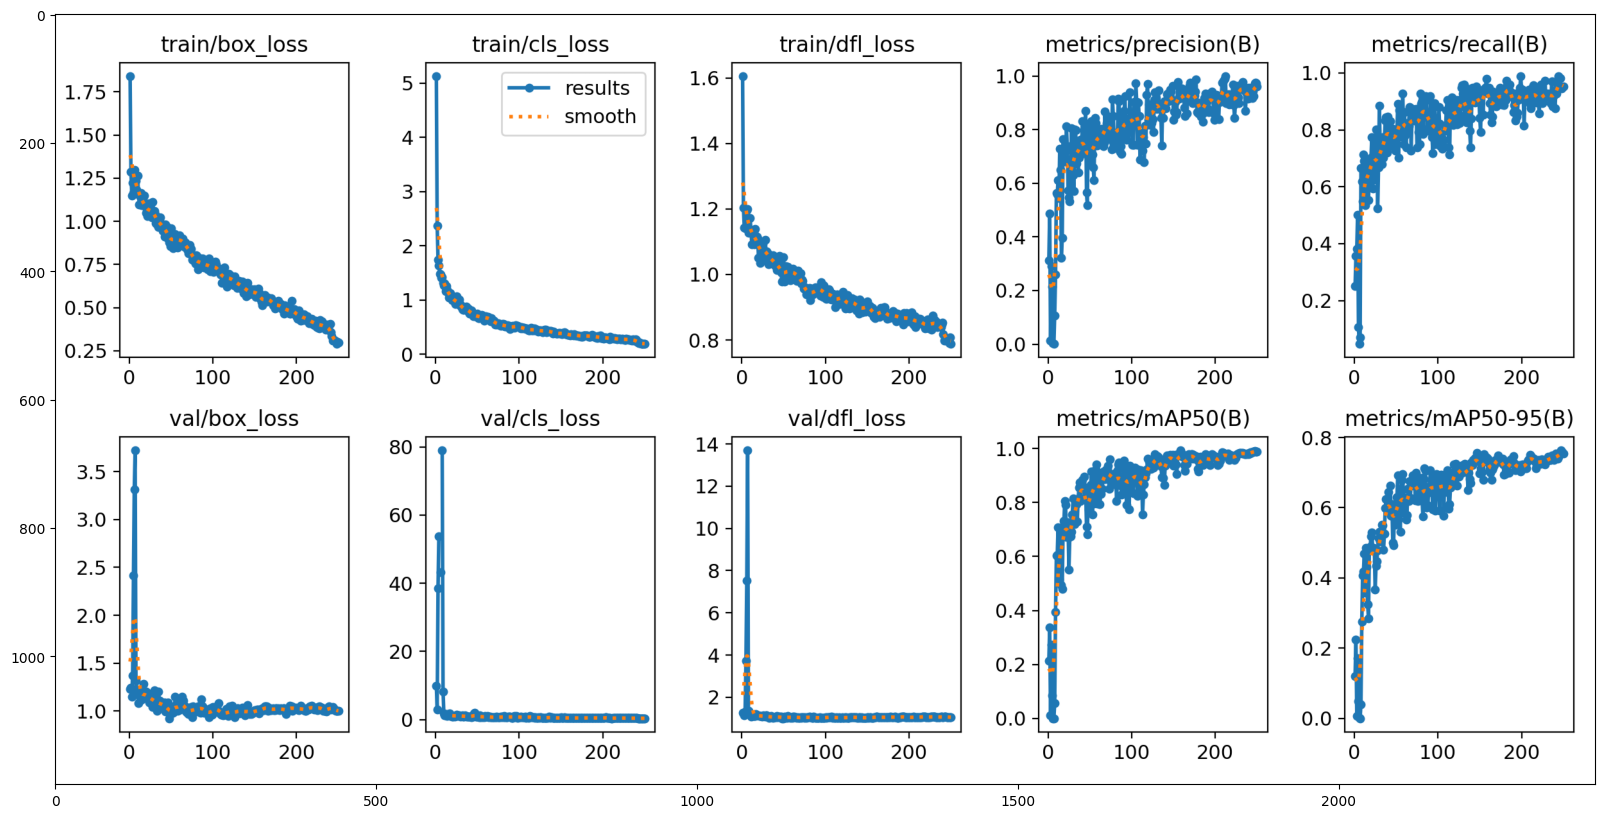

In [14]:
training_output_folder = '/kaggle/working/runs/detect/train'

plt.figure(figsize=(20, 10))
img = Image.open(os.path.join(training_output_folder, 'results.png'))
plt.imshow(img)
plt.show()

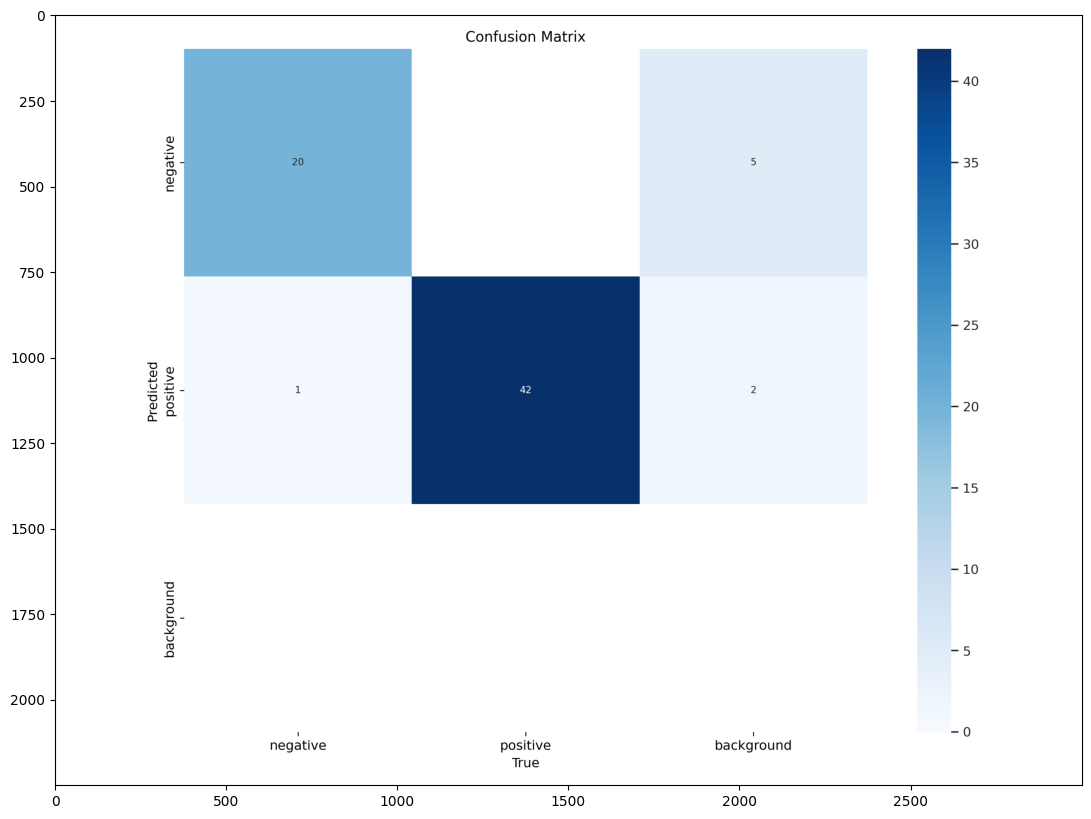

In [15]:
plt.figure(figsize=(20, 10))
img = Image.open(os.path.join(training_output_folder, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

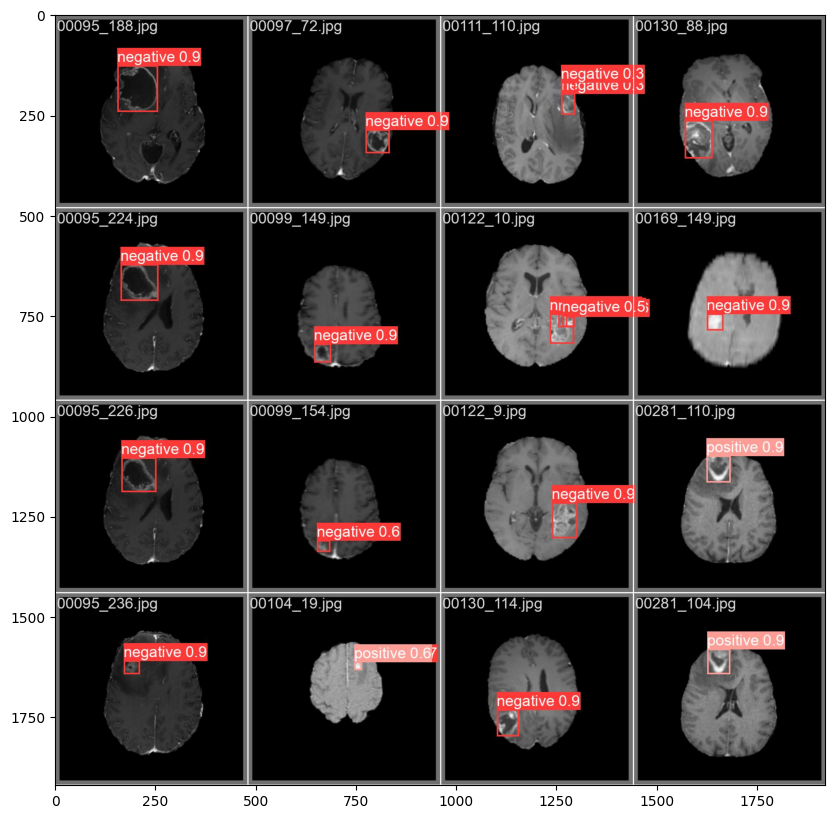

In [16]:
image_path = '/kaggle/working/runs/detect/train/val_batch0_pred.jpg'
plt.figure(figsize=(20, 10))
img = Image.open(image_path)
plt.imshow(img)
plt.show()

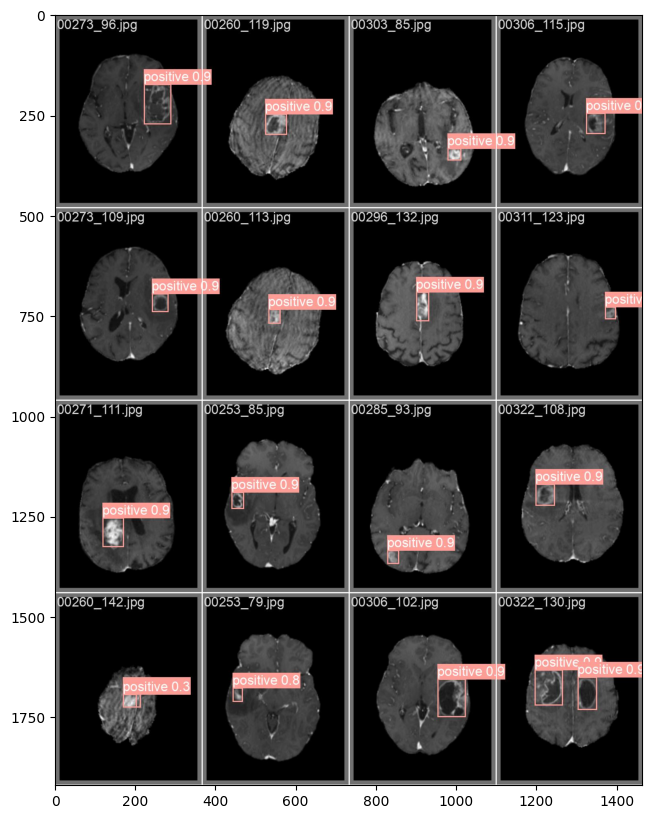

In [17]:
image_path = '/kaggle/working/runs/detect/train/val_batch1_pred.jpg'
plt.figure(figsize=(20, 10))
img = Image.open(image_path)
plt.imshow(img)
plt.show()

In [18]:
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt conf=0.25 source="/kaggle/working/dataset/images/test"

Ultralytics YOLOv8.2.1 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs

image 1/75 /kaggle/working/dataset/images/test/00018_101.jpg: 640x640 1 negative, 7.9ms
image 2/75 /kaggle/working/dataset/images/test/00018_109.jpg: 640x640 1 negative, 8.0ms
image 3/75 /kaggle/working/dataset/images/test/00018_111.jpg: 640x640 1 negative, 8.0ms
image 4/75 /kaggle/working/dataset/images/test/00018_117.jpg: 640x640 1 negative, 7.9ms
image 5/75 /kaggle/working/dataset/images/test/00018_121.jpg: 640x640 1 negative, 7.9ms
image 6/75 /kaggle/working/dataset/images/test/00018_126.jpg: 640x640 1 negative, 7.9ms
image 7/75 /kaggle/working/dataset/images/test/00018_134.jpg: 640x640 1 negative, 7.9ms
image 8/75 /kaggle/working/dataset/images/test/00019_66.jpg: 640x640 1 negative, 1 positive, 7.9ms
image 9/75 /kaggle/working/dataset/images/test/00019_75.jpg: 640x640 2 negatives, 2 positives, 7.9ms
image 10/7

### Predicted vs Real

In [19]:
def draw_img_label(img, label, thickness=2):
    x_size, y_size = img.size
    label_text, cx, cy, w, h = label
    cx = cx * x_size
    cy = cy * y_size
    w = w * x_size
    h = h * y_size
    
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx - w/2, cy - h/2), (cx + w/2, cy + h/2)), outline="blue", width=thickness)
    draw.text((cx - w/2, cy - h/2 - 15), str(label_text), fill="red")
    return img

In [20]:
def draw_img_label(img, label, thickness=2):
    x_size, y_size = img.size
    label_text, cx, cy, w, h = label
    cx = cx * x_size
    cy = cy * y_size
    w = w * x_size
    h = h * y_size
    
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx - w/2, cy - h/2), (cx + w/2, cy + h/2)), outline="blue", width=thickness)
    draw.text((cx - w/2, cy - h/2 - 15), str(label_text), fill="red")
    return img

In [21]:
def show_predicted_vs_real(pred_path, real_path, label_path):
    pred_image = Image.open(pred_path)
    real_image = Image.open(real_path)

    with open(label_path, 'r') as f:
        label = tuple(map(float, f.readline().split()))  # Legge le coordinate come float

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(pred_image)
    axes[0].set_title('Predicted Image')
    axes[0].axis('off')

    axes[1].imshow(real_image)
    axes[1].set_title('Real Image')
    image_with_label = draw_img_label(real_image, label)
    axes[1].imshow(image_with_label, cmap='gray')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

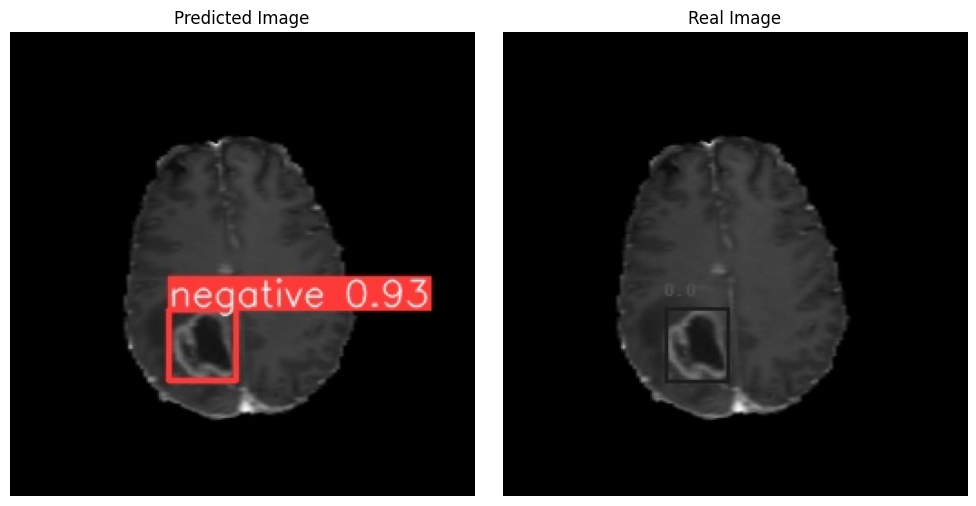

In [22]:
pred_list = os.listdir('/kaggle/working/runs/detect/predict')
image_id = pred_list[4]
# random_images = random.sample(pred_list, 1)

pred_path = os.path.join('/kaggle/working/runs/detect/predict', image_id)
real_path = os.path.join('/kaggle/working/dataset/images/test', image_id)
label_path = os.path.join('/kaggle/working/dataset/labels/test', os.path.splitext(image_id)[0] + '.txt')

show_predicted_vs_real(pred_path,real_path,label_path )

In [23]:
model=YOLO('/kaggle/working/runs/detect/train/weights/best.pt')
results = model.predict(source=real_path, conf=0.25)


image 1/1 /kaggle/working/dataset/images/test/00088_143.jpg: 640x640 1 negative, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


In [24]:
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]
print(bbox)

[87.68115234375, 153.0599365234375, 124.396240234375, 192.6832275390625]


In [25]:
pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ijnl4sp3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ijnl4sp3
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [26]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: {sys.executable}: command not found
--2024-04-18 16:53:48--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: 'sam_vit_h_4b8939.pth'

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   325MB/s    in 7.8s    

2024-04-18 16:53:56 (313 MB/s) - 'sam_vit_h_4b8939.pth' saved [2564550879/2564550879]



In [27]:
image = cv2.cvtColor(cv2.imread(real_path), cv2.COLOR_BGR2RGB)
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = "cuda"
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)

In [28]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [29]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

/opt/conda/lib/python3.10/site-packages/segment_anything/modeling/prompt_encoder.py:199: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:71.)
  y_embed = grid.cumsum(dim=0) - 0.5
/opt/conda/lib/python3.10/site-packages/segment_anything/modeling/prompt_encoder.py:200: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/Context.cpp:71.)
  x_embed = grid.cumsum(dim=1) - 0.5


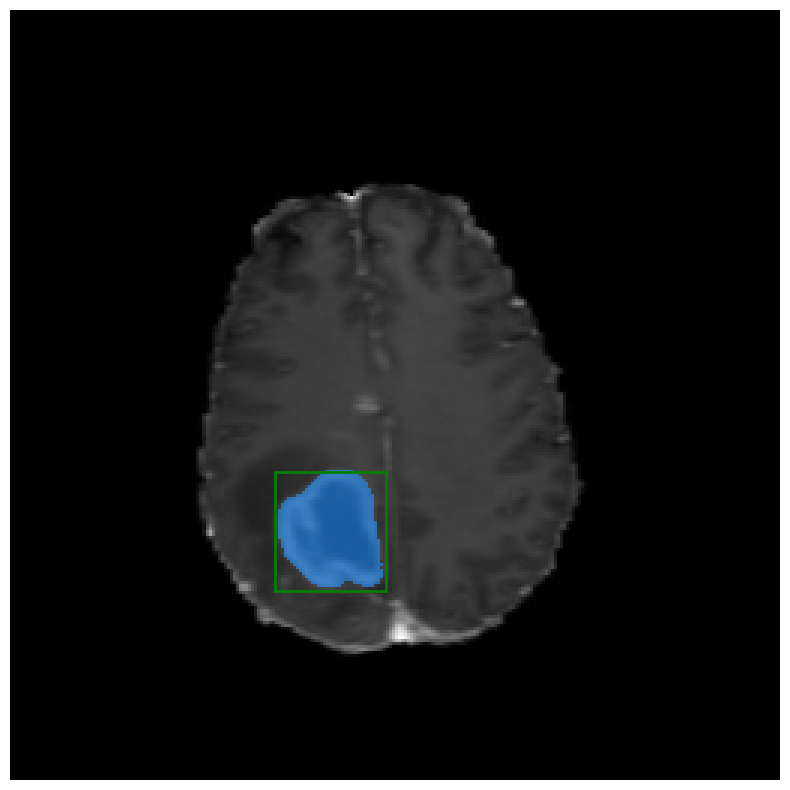

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [31]:
### R-CNN

In [32]:
#!pip uninstall opencv-python opencv-contrib-python opencv-python-headless opencv-contrib-python-headless -y

Found existing installation: opencv-python 4.9.0.80
Uninstalling opencv-python-4.9.0.80:
  Successfully uninstalled opencv-python-4.9.0.80
Found existing installation: opencv-contrib-python 4.9.0.80
Uninstalling opencv-contrib-python-4.9.0.80:
  Successfully uninstalled opencv-contrib-python-4.9.0.80


In [33]:
#!pip uninstall opencv-python opencv-contrib-python opencv-python-headless opencv-contrib-python-headless -y
#!pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (68.3 MB)


In [34]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

In [35]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

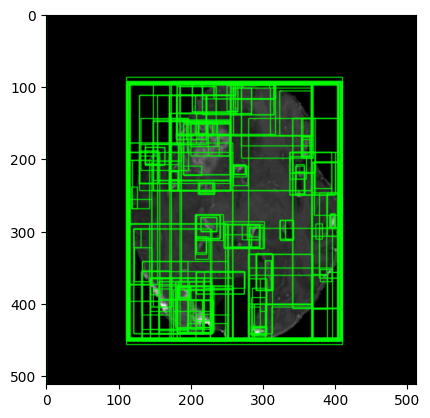

In [36]:
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/train/00095_170.jpg"
im = cv2.imread(path)
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()

imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [37]:
def get_iou(bb1, bb2):
#     print(bb1)
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [38]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [39]:
train_images=[]
train_labels=[]
annot = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/labels/train"
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/train"
for e,i in enumerate(os.listdir(annot)):
    try:
        gtvalues=[]
        filename = i.split(".")[0]+".jpg"
#         print(e,filename)
        image = cv2.imread(os.path.join(path,filename))
        h, w, _ = image.shape
        df = pd.read_csv(os.path.join(annot,i))
        for index, row in df.iterrows():
            label = int(float(row.iloc[0].split(" ")[0]))
            x2 = int(float(row.iloc[0].split(" ")[1]) * w)
            y2 = int(float(row.iloc[0].split(" ")[2]) * h)
            x1 = int(float(row.iloc[0].split(" ")[3]) * w)
            y1 = int(float(row.iloc[0].split(" ")[4]) * h)
            gtvalues.append({"label": label, "x1": x1, "x2": x2, "y1": y1, "y2": y2})

        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
#             print(e)
            if e < 2000 and flag == 0:
#                 print(1)
                for gtval in gtvalues:
                    x,y,w,h = result
#                     print(result)
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
#                     print(1)
                    if counter < 30:
#                         print(1)
                        if iou > 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
#                             print(train_images)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
#                             print(train_images)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
#         print(e)
        print("error in "+filename)
        continue

inside


In [40]:
len(train_images)

471

In [41]:
test_images=[]
test_labels=[]
annot = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/labels/test"
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test"
for e,i in enumerate(os.listdir(annot)):
    try:
        gtvalues=[]
        filename = i.split(".")[0]+".jpg"
#         print(e,filename)
        image = cv2.imread(os.path.join(path,filename))
        h, w, _ = image.shape
        df = pd.read_csv(os.path.join(annot,i))
        for index, row in df.iterrows():
            label = int(float(row.iloc[0].split(" ")[0]))
            x2 = int(float(row.iloc[0].split(" ")[1]) * w)
            y2 = int(float(row.iloc[0].split(" ")[2]) * h)
            x1 = int(float(row.iloc[0].split(" ")[3]) * w)
            y1 = int(float(row.iloc[0].split(" ")[4]) * h)
            gtvalues.append({"label": label, "x1": x1, "x2": x2, "y1": y1, "y2": y2})

        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
#             print(e)
            if e < 2000 and flag == 0:
#                 print(1)
                for gtval in gtvalues:
                    x,y,w,h = result
#                     print(result)
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
#                     print(1)
                    if counter < 30:
#                         print(1)
                        if iou > 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            test_images.append(resized)
#                             print(train_images)
                            test_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            test_images.append(resized)
#                             print(train_images)
                            test_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
#         print(e)
        print("error in "+filename)
        continue

In [42]:
len(test_images)

208

In [43]:
X_train = np.array(train_images)
y_train = np.array(train_labels)
X_test = np.array(test_images)
y_test = np.array(test_labels)

In [44]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

In [45]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>


In [47]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
    
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(inputs = vggmodel.input, outputs = predictions)

<InputLayer name=input_layer, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>


In [48]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

In [49]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [50]:
model_final.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 126,633,474 (483.07 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [51]:
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [52]:
lenc = MyLabelBinarizer()
lenc.fit(y_train)
y_train =  lenc.transform(y_train)
y_test =  lenc.transform(y_test)

In [53]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.keras", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

In [55]:
X_val.shape

(95, 224, 224, 3)

In [56]:
y_val.shape

(95, 2)

In [65]:
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)
# with tf.device("/gpu:0"):
hist = model_final.fit(X_train, y_train, batch_size = 64, epochs= 24, validation_data = (X_val, y_val), callbacks=[checkpoint,early])
# hist = model_final.fit(traindata, epochs= 24, validation_split = 0.2, validation_data=valdata, callbacks=[checkpoint,early])

Epoch 1/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.9395e-04
Epoch 1: val_loss did not improve from 0.07442
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 1.0000 - loss: 4.9866e-04 - val_accuracy: 0.9579 - val_loss: 0.4396
Epoch 2/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.5406e-04
Epoch 2: val_loss did not improve from 0.07442
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 1.0000 - loss: 2.0759e-04 - val_accuracy: 0.9368 - val_loss: 0.5785
Epoch 3/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9996 - loss: 0.0053    
Epoch 3: val_loss did not improve from 0.07442
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.9992 - loss: 0.0089 - val_accuracy: 0.9368 - val_loss: 0.4665
Epoch 4/24
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9971 - loss: 0.0054
Epoch 4: val_loss did not improve from 0.07442
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.9967 - loss: 0.0060 - val_accuracy: 0.9579 - val_loss: 0.2

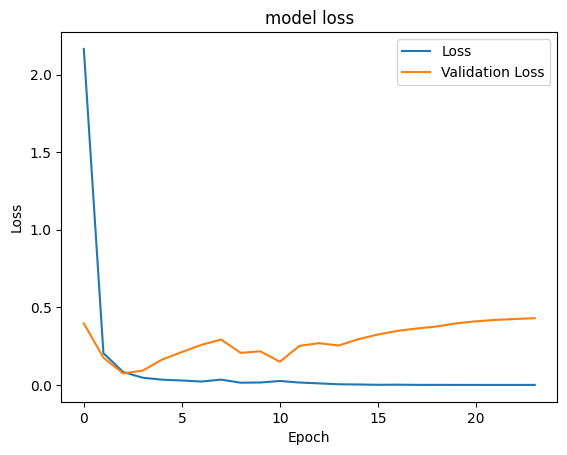

<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [66]:
test_loss, accuracy = model_final.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Accuracy:", accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8363 - loss: 0.4868
Test loss: 0.3563050329685211
Accuracy: 0.8653846383094788


In [67]:
tr_loss, accuracy = model_final.evaluate(X_train, y_train)
print("Train loss:", tr_loss)
print("Accuracy:", accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 0.0010    
Train loss: 0.002295479644089937
Accuracy: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

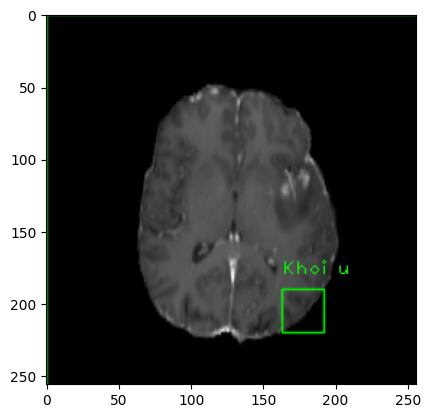

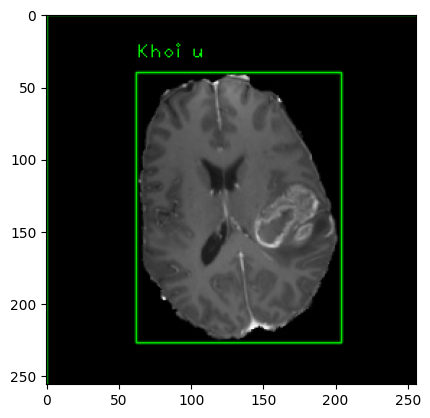

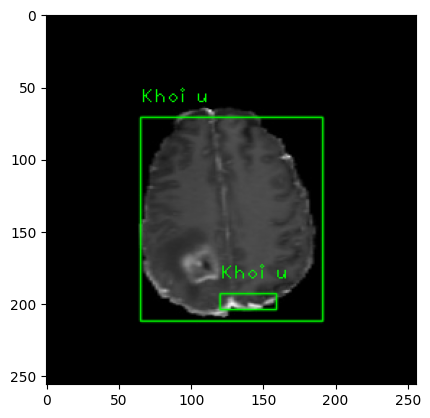

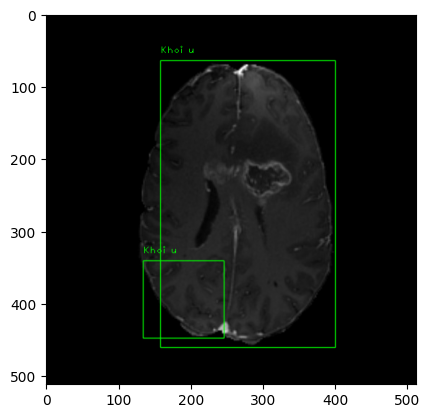

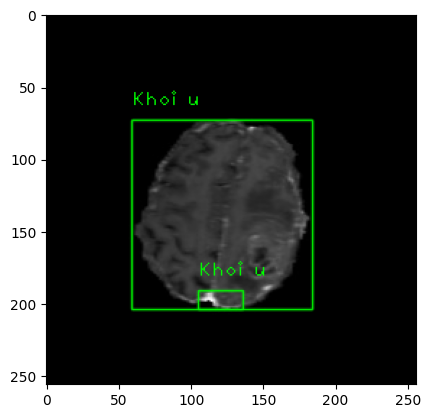

In [73]:
z=0
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test"
img_path = os.listdir(path)[:5]
boxes = []
scores = []
classes = []
for img_name in img_path:
    img = cv2.imread(os.path.join(path, img_name))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    
    boxes = []
    scores = []
    classes = []
    
    for e, result in enumerate(ssresults):
        if e < 2000:
            x, y, w, h = result
            timage = imout[y:y+h, x:x+w]
            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out = model_final.predict(img)
            
            boxes.append(result)
            scores.append(out.max())
            if out[0][1] > 0.99:
                classes.append(1)
            else:
                classes.append(0)
    
    # Thực hiện non-maximum suppression
    selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=2, iou_threshold=0.9)
    selected_boxes = tf.gather(boxes, selected_indices)
    
    # Vẽ box và hiển thị ảnh
    for box in selected_boxes:
        x, y, w, h = box[:4]
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)
        
        if classes[i] == 0:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(imout, 'Binh thuong', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (255, 0, 0), 1)
        else:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            cv2.putText(imout, 'Khoi u', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
    
    # Hiển thị ảnh
    plt.figure()
    plt.imshow(imout)

In [70]:
selected_boxes

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[107, 143,  20,  32],
       [ 64,  42, 137, 181]], dtype=int32)>

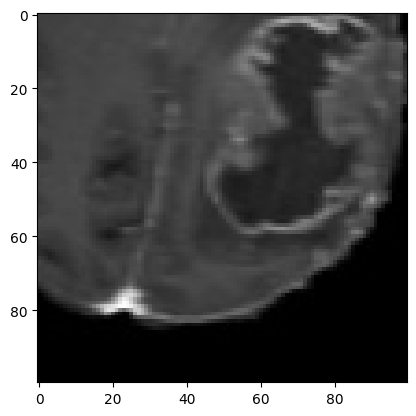

In [71]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from pylab import*

Image = cv2.imread("/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_121.jpg")
# Image = Image[y:y+h, x:x+w]
x = 256//3
y = 256//2
w = 100
h = 100
Image = Image[y:y+h, x:x+w]
# Image = img_arr[0]
plt.imshow(Image)

/tmp/ipykernel_34/2765625310.py:12: UserWarning: The following kwargs were not used by contour: 'color', 'linewidth'
  plt.contour(IniLSF,[0],color = 'b',linewidth=2)


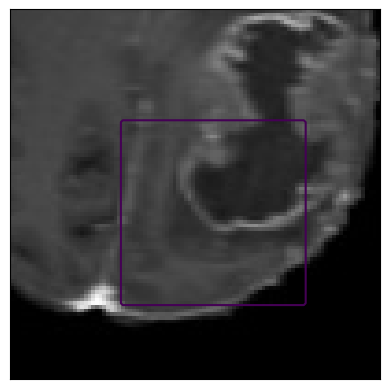

/tmp/ipykernel_34/2765625310.py:64: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(LSF,[0],colors='r',linewidth=2)


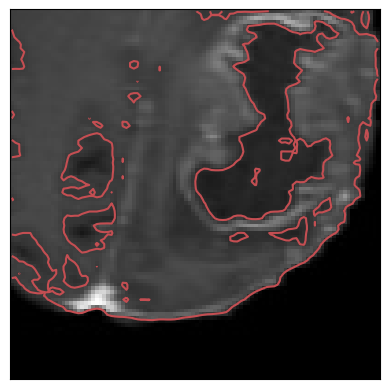

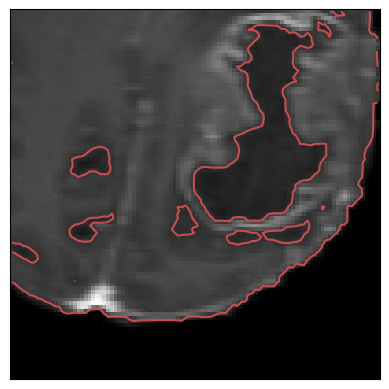

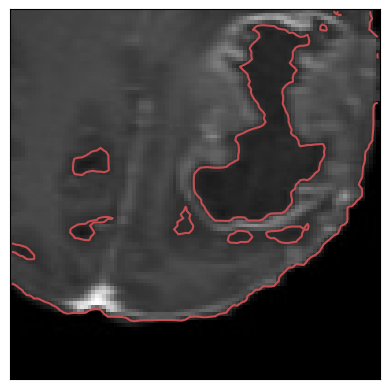

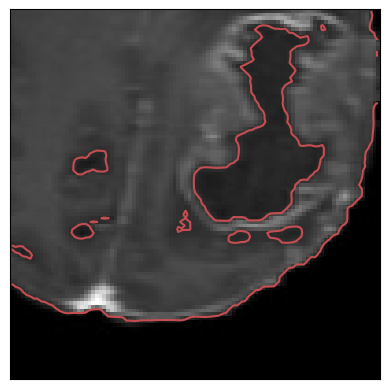

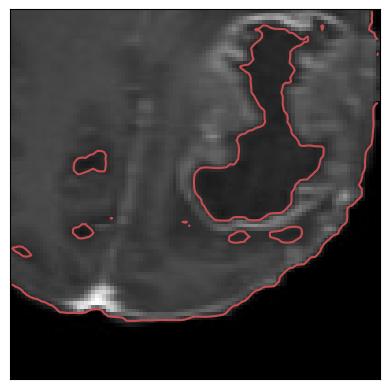

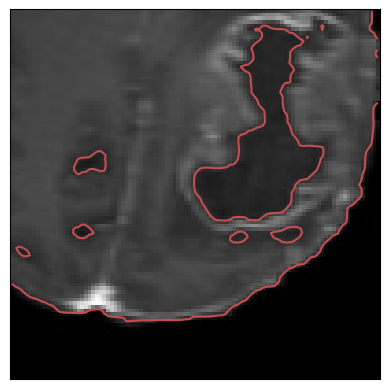

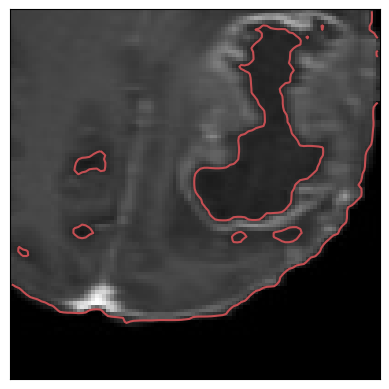

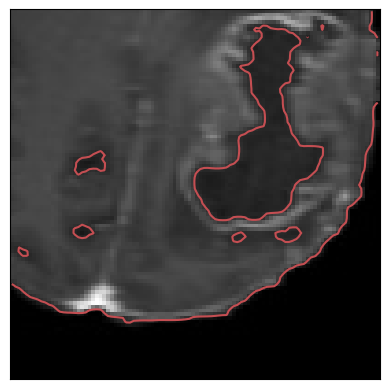

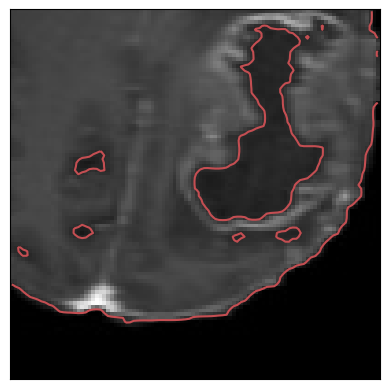

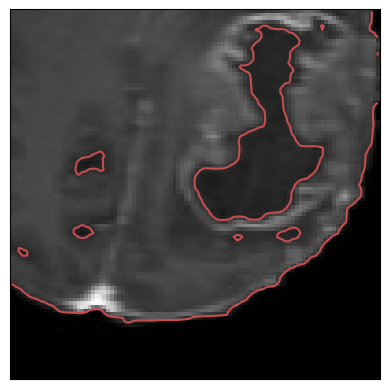

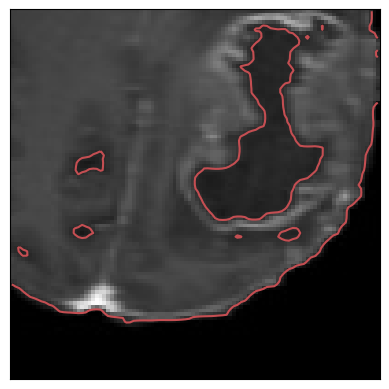

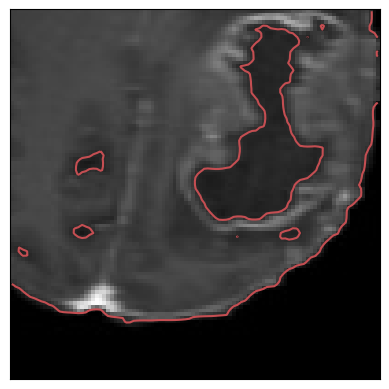

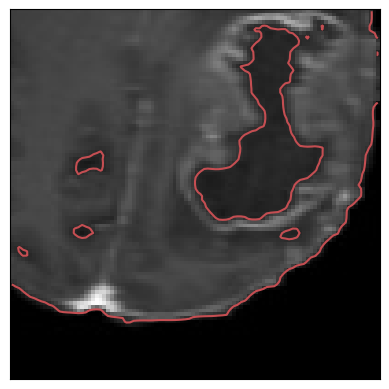

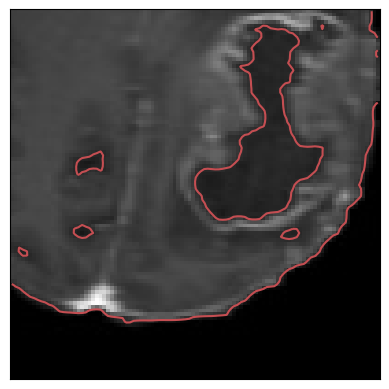

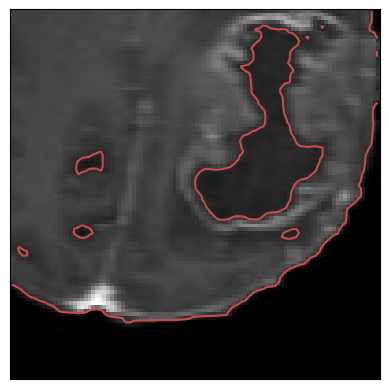

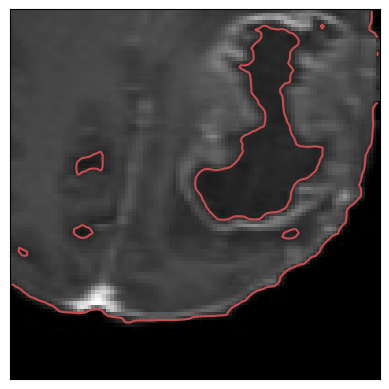

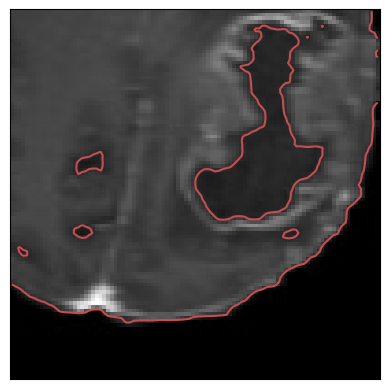

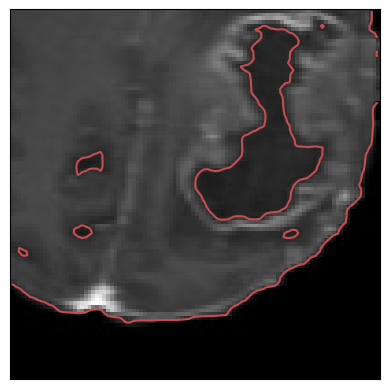

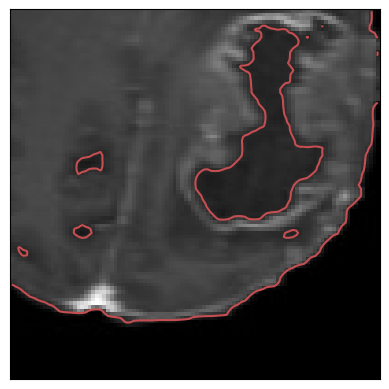

In [72]:
image = cv2.cvtColor(Image,cv2.COLOR_BGR2GRAY)
img=np.array(image,dtype=np.float64) 


IniLSF = np.ones((img.shape[0],img.shape[1]),img.dtype) 
IniLSF[30:80,30:80]= -1 
IniLSF=-IniLSF 


Image = cv2.cvtColor(Image,cv2.COLOR_BGR2RGB) 
plt.figure(1),plt.imshow(Image),plt.xticks([]), plt.yticks([])   # to hide tick values on X and Y axis
plt.contour(IniLSF,[0],color = 'b',linewidth=2)  
plt.draw(),plt.show(block=False) 

def mat_math (intput,str):
    output=intput 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if str=="atan":
                output[i,j] = math.atan(intput[i,j]) 
            if str=="sqrt":
                output[i,j] = math.sqrt(intput[i,j]) 
    return output 


def CV (LSF, img, mu, nu, epison,step):

    Drc = (epison / math.pi) / (epison*epison+ LSF*LSF)
    Hea = 0.5*(1 + (2 / math.pi)*mat_math(LSF/epison,"atan")) 
    Iy, Ix = np.gradient(LSF) 
    s = mat_math(Ix*Ix+Iy*Iy,"sqrt") 
    Nx = Ix / (s+0.000001) 
    Ny = Iy / (s+0.000001) 
    Mxx,Nxx =np.gradient(Nx) 
    Nyy,Myy =np.gradient(Ny) 
    cur = Nxx + Nyy 
    Length = nu*Drc*cur 

    Lap = cv2.Laplacian(LSF,-1) 
    Penalty = mu*(Lap - cur) 

    s1=Hea*img 
    s2=(1-Hea)*img 
    s3=1-Hea 
    C1 = s1.sum()/ Hea.sum() 
    C2 = s2.sum()/ s3.sum() 
    CVterm = Drc*(-1 * (img - C1)*(img - C1) + 1 * (img - C2)*(img - C2)) 

    LSF = LSF + step*(Length + Penalty + CVterm) 
    #plt.imshow(s, cmap ='gray'),plt.show() 
    return LSF 


mu = 1 
nu = 0.003 * 255 * 255 
num = 20 
epison = 1 
step = 0.1 
LSF=IniLSF 
for i in range(1,num):
    LSF = CV(LSF, img, mu, nu, epison,step) 
    if i % 1 == 0:   
        plt.imshow(Image),plt.xticks([]), plt.yticks([])  
        plt.contour(LSF,[0],colors='r',linewidth=2) 
        plt.draw(),plt.show(block=False),plt.pause(0.01) 